<h1><center><b> PCV LAB - 11 </b></center></h1>

## Understand and apply deblurring based on weiner filtering


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/motion-blur/guoer_slide.jpg
/kaggle/input/motion-blur/th.jpg
/kaggle/input/motion-blur/guoer.jpg
/kaggle/input/motion-blur/child.jpg
/kaggle/input/motion-blur/bookfigure.png
/kaggle/input/deblur-gan/deblur-gan/requirements-gpu.txt
/kaggle/input/deblur-gan/deblur-gan/train.py
/kaggle/input/deblur-gan/deblur-gan/th.jpg
/kaggle/input/deblur-gan/deblur-gan/losses.py
/kaggle/input/deblur-gan/deblur-gan/test.py
/kaggle/input/deblur-gan/deblur-gan/model.py
/kaggle/input/deblur-gan/deblur-gan/README.md
/kaggle/input/deblur-gan/deblur-gan/utils.py
/kaggle/input/deblur-gan/deblur-gan/requirements.txt
/kaggle/input/deblur-gan/deblur-gan/generator.h5
/kaggle/input/deblur-gan/deblur-gan/layer_utils.py
/kaggle/input/deblur-gan/deblur-gan/deblur_image.py
/kaggle/input/deblur-gan/deblur-gan/organize_gopro_dataset.py


In the next cell the make_blurred(input, PSF, eps) function is used to blur the image first, and then inverse(input, PSF, eps)and wiener(input, PSF, eps, K=0.01) function are used to restore the original image.

(4896, 6528)
2447.5


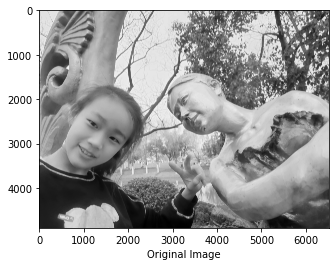

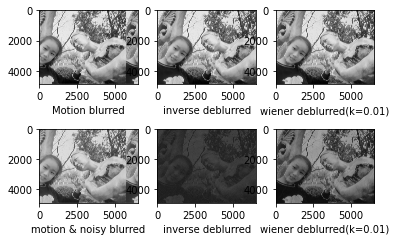

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2


# Simulated motion blur
def motion_process(image_size, motion_angle):
    PSF = np.zeros(image_size)
    print(image_size)
    center_position = (image_size[0] - 1) / 2
    print(center_position)

    slope_tan = math.tan(motion_angle * math.pi / 180)
    slope_cot = 1 / slope_tan
    if slope_tan <= 1:
        for i in range(15):
            offset = round(i * slope_tan)  # ((center_position-i)*slope_tan)
            PSF[int(center_position + offset), int(center_position - offset)] = 1
        return PSF / PSF.sum()  # Normalize the luminance of the point spread function
    else:
        for i in range(15):
            offset = round(i * slope_cot)
            PSF[int(center_position - offset), int(center_position + offset)] = 1
        return PSF / PSF.sum()


# Blur the image with motion
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)  # Take the Fourier transform of a two-dimensional array
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred


def inverse(input, PSF, eps):  # Inverse filtering
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps  # Noise power, that's given，consider epsilon
    result = fft.ifft2(input_fft / PSF_fft)  # Compute the inverse Fourier transform of F(u,v)
    result = np.abs(fft.fftshift(result))
    return result


def wiener(input, PSF, eps, K=0.01):  # Wiener filtering，K=0.01
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps
    PSF_fft_1 = np.conj(PSF_fft) / (np.abs(PSF_fft) ** 2 + K)
    result = fft.ifft2(input_fft * PSF_fft_1)
    result = np.abs(fft.fftshift(result))
    return result


image = cv2.imread('../input/motion-blur/guoer.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale image
img_h = image.shape[0]
img_w = image.shape[1]
plt.figure(1)
plt.xlabel("Original Image")
plt.gray()
plt.imshow(image)  # Show the original image
plt.figure(2)
plt.gray()
# Motion blur
PSF = motion_process((img_h, img_w), 60)
blurred = np.abs(make_blurred(image, PSF, 1e-3))

plt.subplot(231)
plt.xlabel("Motion blurred")
plt.imshow(blurred)

result = inverse(blurred, PSF, 1e-3)  # Inverse filtering
plt.subplot(232)
plt.xlabel("inverse deblurred")
plt.imshow(result)

result = wiener(blurred, PSF, 1e-3)  # Wiener filtering
plt.subplot(233)
plt.xlabel("wiener deblurred(k=0.01)")
plt.imshow(result)

blurred_noisy = blurred + 0.1 * blurred.std() * \
                np.random.standard_normal(blurred.shape)  # Add noise,standard_normal is Generating random functions

plt.subplot(234)
plt.xlabel("motion & noisy blurred")
plt.imshow(blurred_noisy)  # Displays images with added noise and motion blur

result = inverse(blurred_noisy, PSF, 0.1 + 1e-3)  # The image with added noise is inversely filtered
plt.subplot(235)
plt.xlabel("inverse deblurred")
plt.imshow(result)

result = wiener(blurred_noisy, PSF, 0.1 + 1e-3)  # Wiener filtering is performed on the image with added noise
plt.subplot(236)
plt.xlabel("wiener deblurred(k=0.01)")
plt.imshow(result)

plt.show()

When we do not know how to blur the motion of the image, we need to adjust the parameters of the degradation model according to the degradation of the specific picture to get a better effect.

When a = 1e-6，b = 0.1，T = 0.1，K = 1e-11，the result is shown in the output.

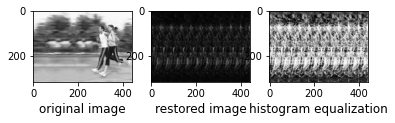

In [3]:
# Wiener filtering is used to restore the image
import cv2
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt
import cmath


def degradation_function(m, n,a,b,T):
    P = m / 2 + 1
    Q = n / 2 + 1
    Mo = np.zeros((m, n), dtype=complex)
    for u in range(m):
        for v in range(n):
            temp = cmath.pi * ((u - P) * a + (v - Q) * b)
            if temp == 0:
                Mo[u, v] = T
            else:
                Mo[u, v] = T * cmath.sin(temp) / temp * cmath.exp(- 1j * temp)
    return Mo


def image_mapping(image):
    img = image/np.max(image)*255
    return img


if __name__ == '__main__':
    img = cv2.imread('../input/motion-blur/th.jpg',0)
    m, n = img.shape
    a = 1e-6
    b = 0.1
    T = 0.1
    K = 1e-11
    G = fft.fft2(img)
    G_shift = fft.fftshift(G)
    H = degradation_function(m, n,a,b,T)

    F = G_shift *((np.abs(H)*np.abs(H)) / (H*np.abs(H)*np.abs(H)+K))

    f_pic = np.abs(fft.ifft2(F))
    res = image_mapping(f_pic)
    res1 = res.astype('uint8')
    res1 = cv2.medianBlur(res1, 3)

    res2 = cv2.equalizeHist(res1)

    plt.subplot(131)
    plt.imshow(img,cmap='gray')
    plt.xlabel('original image', fontproperties='FangSong', fontsize=12)

    plt.subplot(132)
    plt.imshow(res1,cmap='gray')
    plt.xlabel('restored image', fontproperties='FangSong', fontsize=12)
    plt.subplot(133)
    plt.imshow(res2,cmap='gray')
    plt.xlabel('histogram equalization', fontproperties='FangSong', fontsize=12)
    plt.show()


When  a = 1e-5，b =0.1 ，T = 0.1，r = 0.000005，the result is shown in the output.

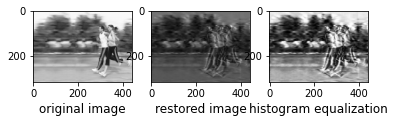

In [4]:
# Image restoration using least square method
import cv2
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt
import cmath


def degradation_function(m, n,a,b,T):
    P = m / 2 + 1
    Q = n / 2 + 1
    Mo = np.zeros((m, n), dtype=complex)
    for u in range(m):
        for v in range(n):
            temp = cmath.pi * ((u - P) * a + (v - Q) * b)
            if temp == 0:
                Mo[u, v] = T
            else:
                Mo[u, v] = T * cmath.sin(temp) / temp * cmath.exp(- 1j * temp)
    return Mo

def image_mapping(image):
    img = image/np.max(image)*255
    return img


if __name__ == '__main__':
    img = cv2.imread('../input/motion-blur/th.jpg',0)
    m, n = img.shape
    a = 1e-5
    b = 0.1
    T = 0.1
    r = 0.000005
    G = fft.fft2(img)
    G_shift = fft.fftshift(G)
    H = degradation_function(m, n,a,b,T)
    p = np.array([[0,-1,0],
                  [-1,4,-1],
                  [0,-1,0]])
    P = fft.fft2(p,[img.shape[0],img.shape[1]])
    F = G_shift *(np.conj(H) / (np.abs(H)**2+r*np.abs(P)**2))

    f_pic = np.abs(fft.ifft2(F))
    res = image_mapping(f_pic)
    res1 = res.astype('uint8')
    #res1 = cv2.medianBlur(res1, 3)
    res2 = cv2.equalizeHist(res1)

    plt.subplot(131)
    plt.imshow(img,cmap='gray')
    plt.xlabel('original image', fontproperties='FangSong', fontsize=12)
    plt.subplot(132)
    plt.imshow(res1,cmap='gray')
    plt.xlabel('restored image', fontproperties='FangSong', fontsize=12)
    plt.subplot(133)
    plt.imshow(res2,cmap='gray')
    plt.xlabel('histogram equalization', fontproperties='FangSong', fontsize=12)
    plt.show()
